# 1. Importing libraries

In [7]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_preprocess import preprocess
from src.support_eda import plot_relation_tv
from src.support_clustering import *


# 2. Data loading

In [8]:
df = pd.read_csv('../data/processed/orders.csv', index_col=0)

df.head()

,ShipMode,OrderPriority,NumberOfProducts,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
OrderID,,,,,,,
AE-2011-9160,Standard Class,Medium,2,161.082,8,-246.078,9.56
AE-2013-1130,Same Day,High,2,228.996,7,-236.964,60.18
AE-2013-1530,Second Class,High,2,23.634,3,-38.076,3.16
AE-2014-2840,First Class,Critical,1,42.480,1,-75.060,8.04
AE-2014-3830,Standard Class,Medium,6,281.502,16,-429.108,19.38


# 3. Preprocessing

* Remove the columns we do not want to consider.

    - In this case, we are not going to remove any columns.

* Select the encoding methods for categorical variables.

    - We only have the categorical variables `ShipMode` and `OrderPriority` We will perform a Frequency Encoding.

* Select the scaling method.

    - We will initially try using a minmax scaler.

In [9]:
encoding_methods = {"frequency": ['ShipMode', 'OrderPriority']}

scaling = 'robust'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling)

In [10]:
df_encoded.head()

,ShipMode,OrderPriority,NumberOfProducts,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
OrderID,,,,,,,
AE-2011-9160,0.597284,0.570441,2,161.082,8,-246.078,9.56
AE-2013-1130,0.052686,0.305093,2,228.996,7,-236.964,60.18
AE-2013-1530,0.200320,0.305093,2,23.634,3,-38.076,3.16
AE-2014-2840,0.149710,0.077531,1,42.480,1,-75.060,8.04
AE-2014-3830,0.597284,0.570441,6,281.502,16,-429.108,19.38


In [11]:
df_scaled.head()

,ShipMode,OrderPriority,NumberOfProducts,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
OrderID,,,,,,,
AE-2011-9160,0.000000,0.000000,0.0,-0.082849,0.500000,-2.984602,-0.183791
AE-2013-1130,-1.371906,-1.000000,0.0,0.040169,0.333333,-2.882397,0.755007
AE-2013-1530,-1.000000,-1.000000,0.0,-0.331819,-0.333333,-0.652053,-0.302485
AE-2014-2840,-1.127490,-1.857594,-0.5,-0.297682,-0.666667,-1.066794,-0.211981
AE-2014-3830,0.000000,0.000000,2.0,0.135277,1.833333,-5.037113,-0.001669


# 4. Clustering

We are going to implement different clustering algorithms to see how the customers are segmented.

## 4.1 K-means

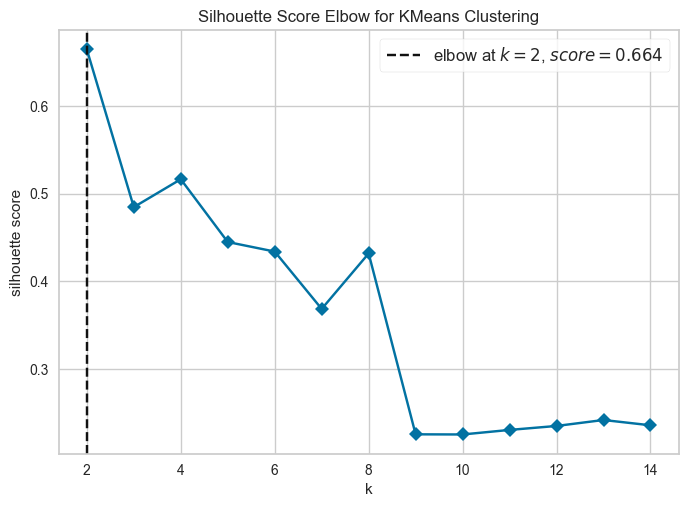

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [12]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df_scaled)
visualizer.show()

Using the elbow technique and the selected preprocessing, we obtain 2 clusters, $k = 2$, and a silhouette score of 0.664(relatively close to 1).  

This means that the data appear to group moderately well into 4 clusters and that there is no significant overlap between them.

In [13]:
model_kmeans = KMeans(n_clusters=2)

km_fit = model_kmeans.fit(df_scaled)
labels = km_fit.labels_

### 4.1.1 Metrics

In [14]:
clustering_metrics(df_scaled, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.614673,0.918417,24218
1,0.614673,0.918417,817


We observe a Davies-Bouldin index of 0.92, which falls between 0 and 1, indicating moderately adequate cluster compactness and separation (0 is better than 1).

Additionally, by looking at the cluster cardinality, we can confirm that both have a good size, without significant imbalances.

### 4.1.2 Cluster exploration

In this section, we will compare the obtained clusters to identify their properties.

In [15]:
df_kmeans = df_scaled.copy()

df_kmeans['cluster'] = km_fit.labels_

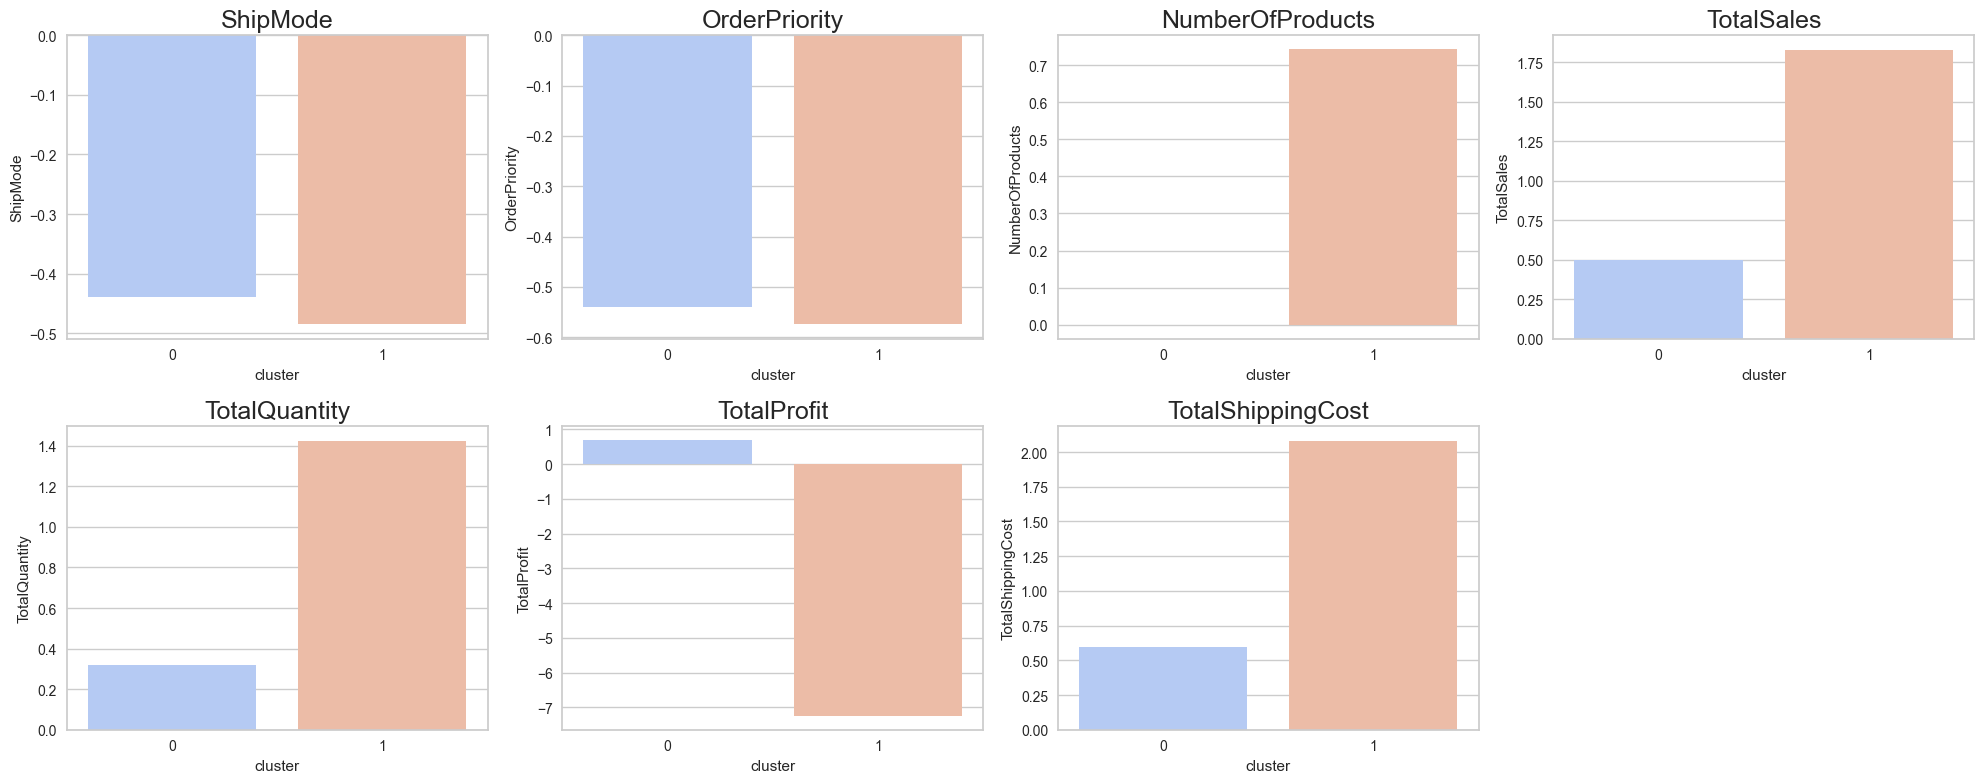

In [16]:
plot_clusters(df_kmeans)

It appears that the main difference between the orders lies in those that generate higher profits and those that generate lower profits (possibly even losses). Additionally, there seems to be some relationship with the number of products shipped, shipping costs, and sales revenue.  

This clustering seems very insightful, so we will analyze it in detail later.

#### Radar plot

By creating a radar chart, we can also examine the differences between clusters. Let’s represent the numerical variables.

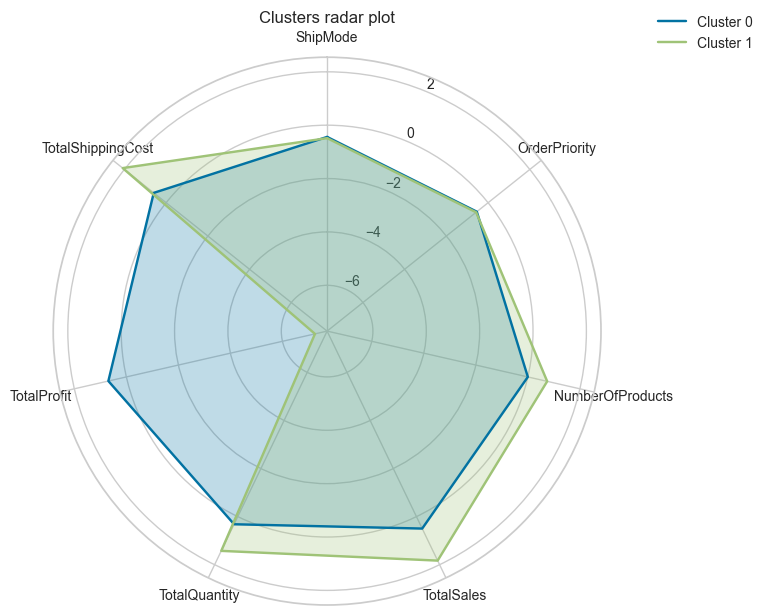

In [19]:
variables = ['ShipMode', 'OrderPriority', 'NumberOfProducts', 'TotalSales',
       'TotalQuantity', 'TotalProfit', 'TotalShippingCost']

plot_radar(df_kmeans, variables)

#### Histograms

Below, we can see a more detailed distribution of the variables based on the cluster. However, due to the imbalance of the clusters, it is easier to visualize them in the radar plot.

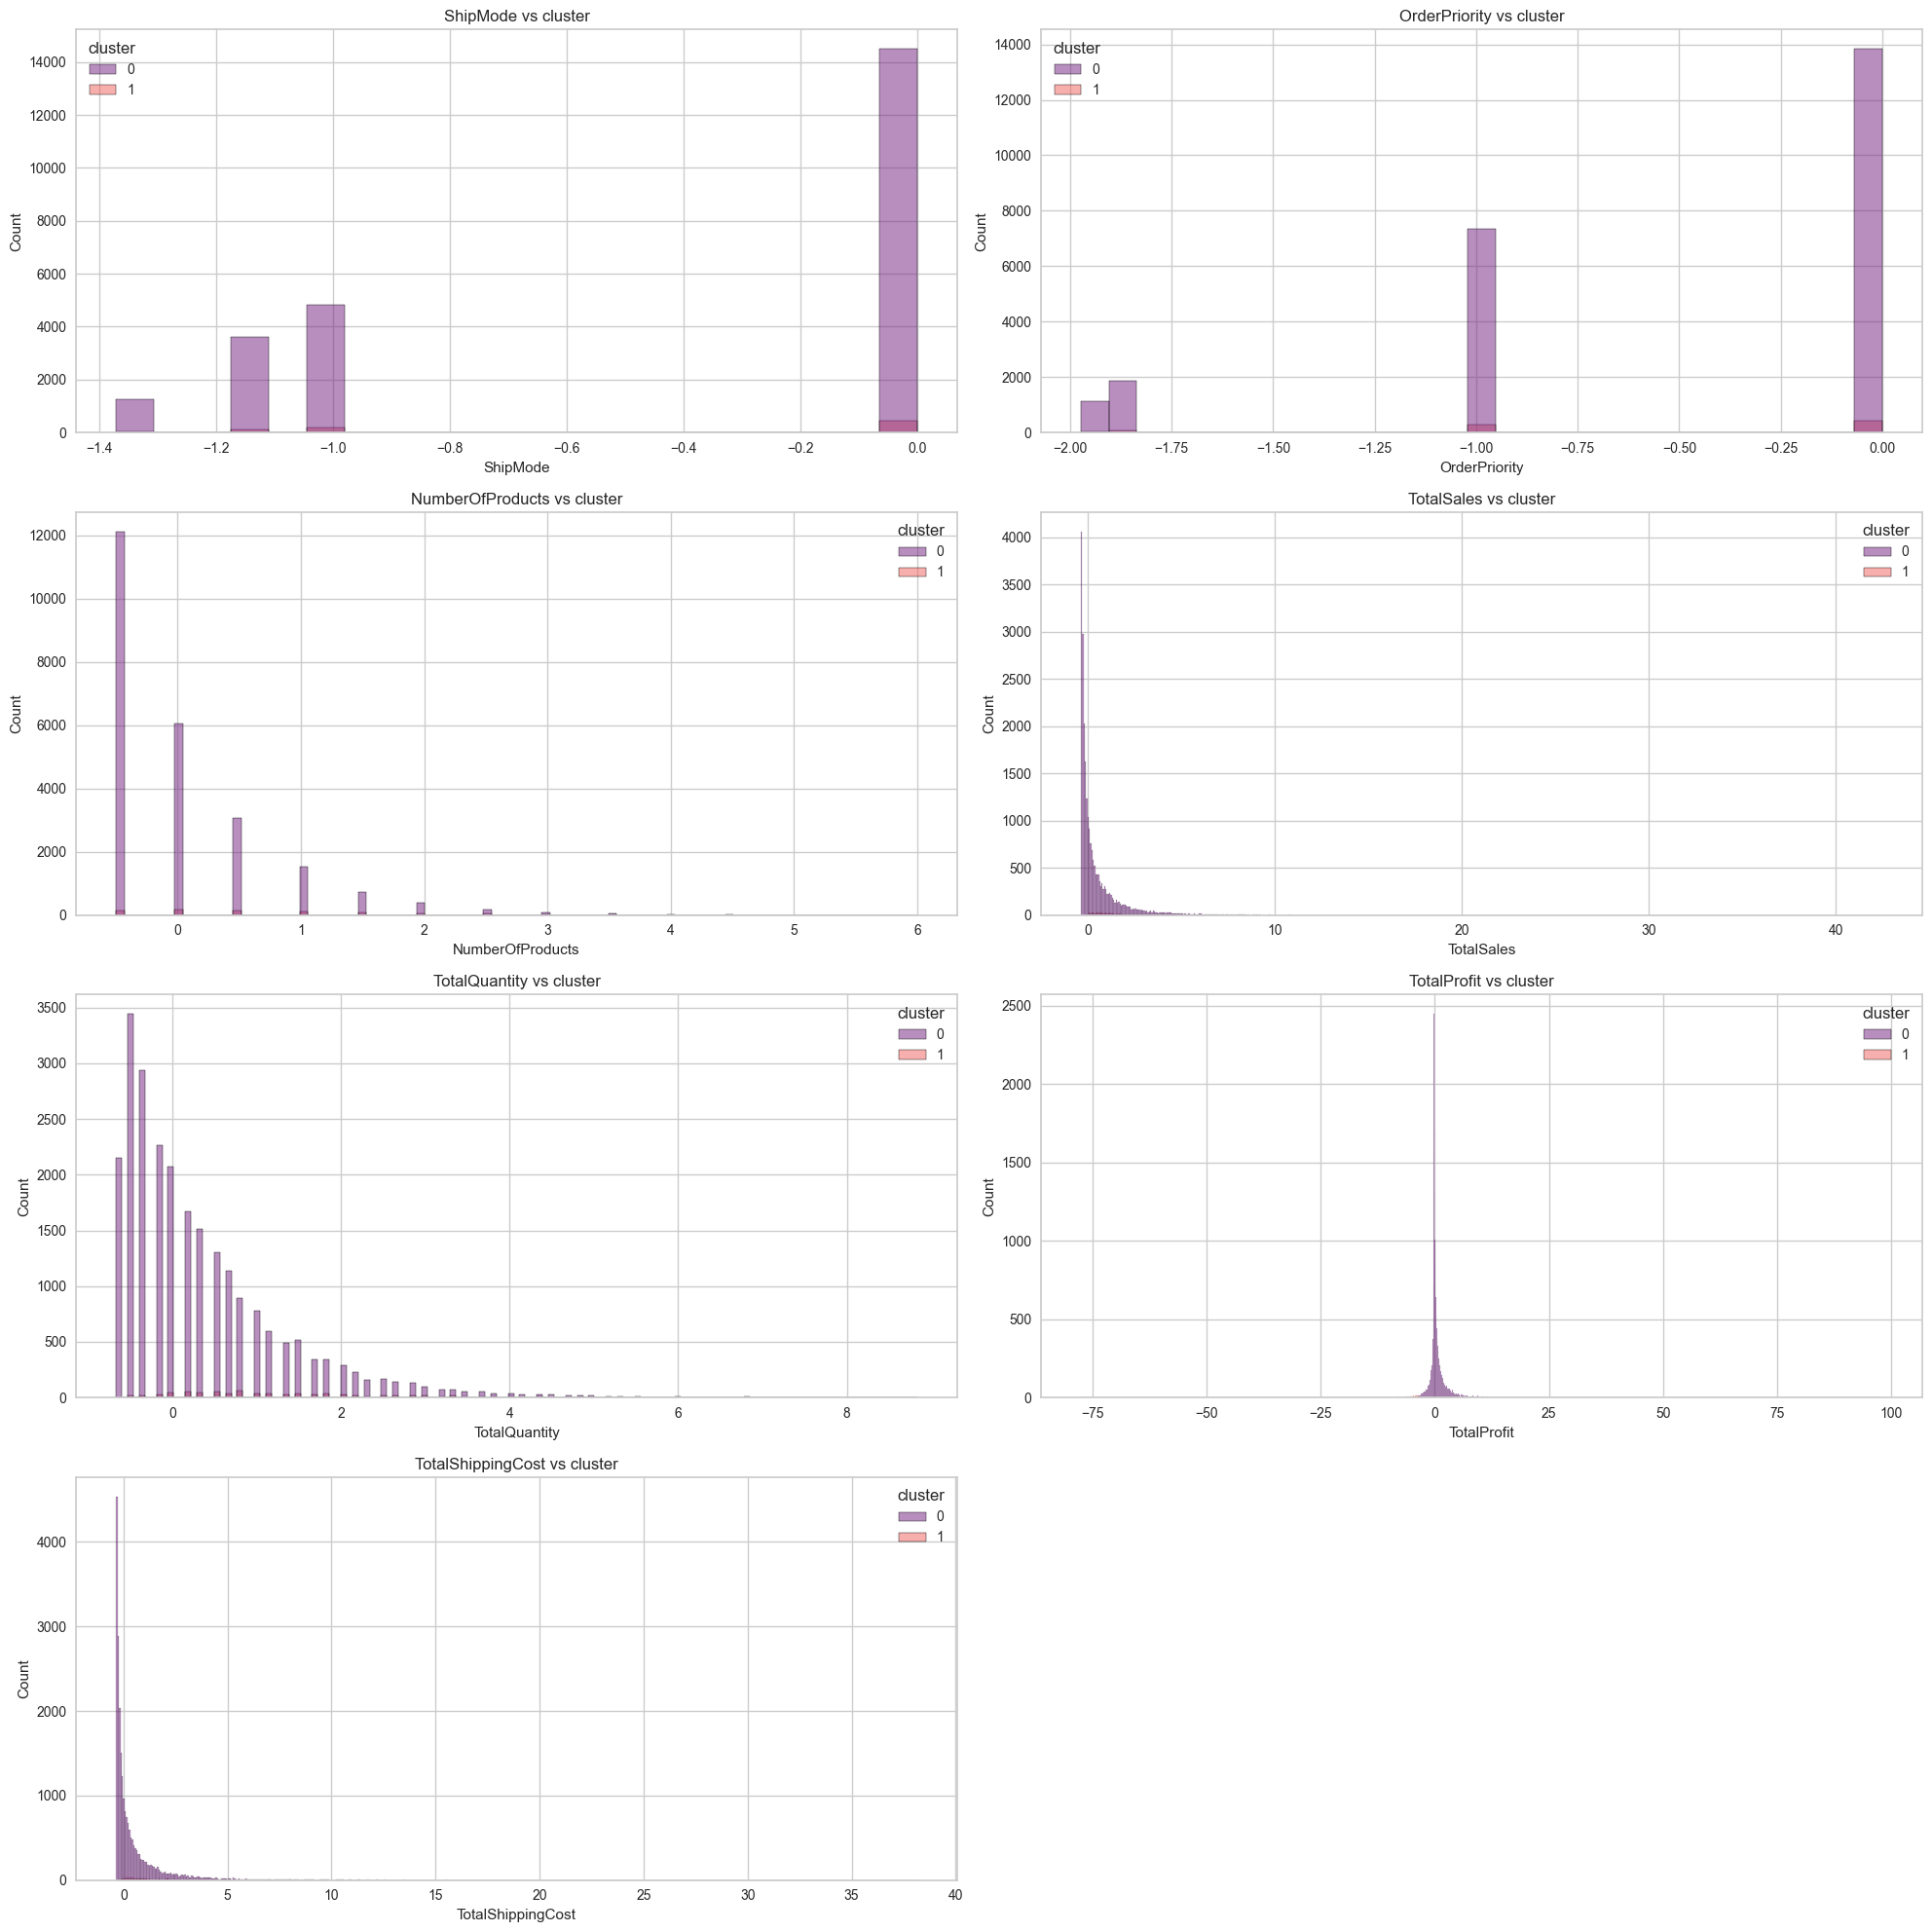

In [20]:
plot_relation_tv(df_kmeans, 'cluster', size=(20, 20), n_cols = 2)

## 4.2 Agglomerative clustering

This time, we will use an agglomerative hierarchical clustering model.  

Let’s start by visualizing the dendrograms associated with each type of linkage we can use.

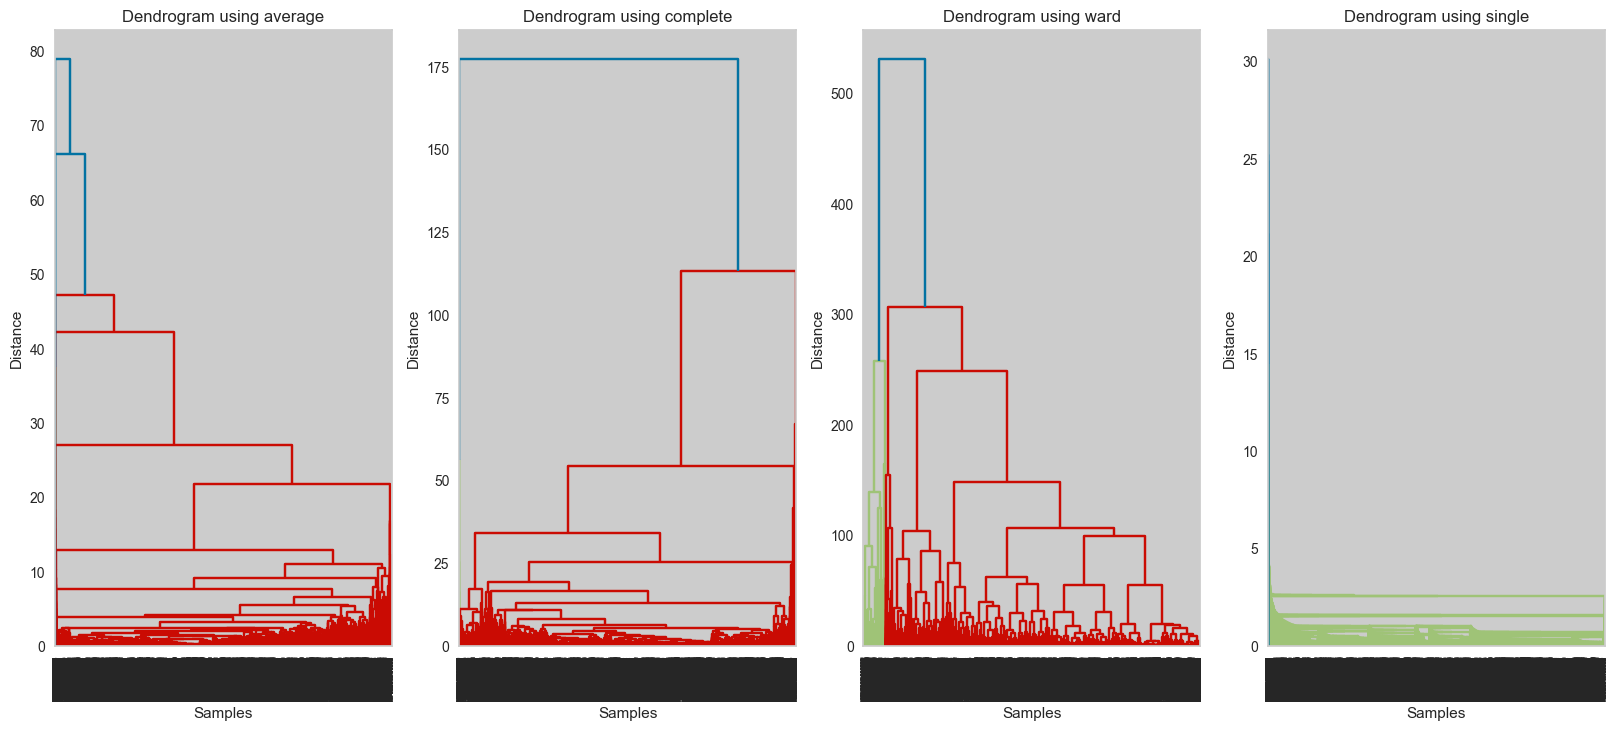

In [21]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)

In [22]:
results_df = agglomerative_methods(df_copy)

Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.


In [23]:
best_model = results_df.sort_values(by='ranking_score', ascending=False).iloc[0]

best_model

linkage                            complete
metric                               cosine
silhouette_score                   0.288394
davies_bouldin_index                1.81885
cluster_cardinality     {0: 15076, 1: 9959}
n_cluster                                 2
balance_score                      1.513807
ranking_score                     -3.044263
Name: 4, dtype: object

The best model uses a 'complete' linkage, a cosine metric, and once again, 2 clusters.

In [24]:
model = AgglomerativeClustering(
    linkage=best_model['linkage'],
    metric=best_model['metric'],
    distance_threshold=None,
    n_clusters=best_model['n_cluster']
)

agglo_fit = model.fit(df_scaled)
agglo_labels = agglo_fit.labels_

In [25]:
clustering_metrics(df_scaled, agglo_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.175511,1.81885,15076
1,0.175511,1.81885,9959


The metrics obtained are significantly worse than with the K-Means algorithm, although the clusters are more evenly populated.

### 4.2.2 Cluster exploration

In [26]:
df_agg = df_scaled.copy()
df_agg["cluster"] = agglo_labels

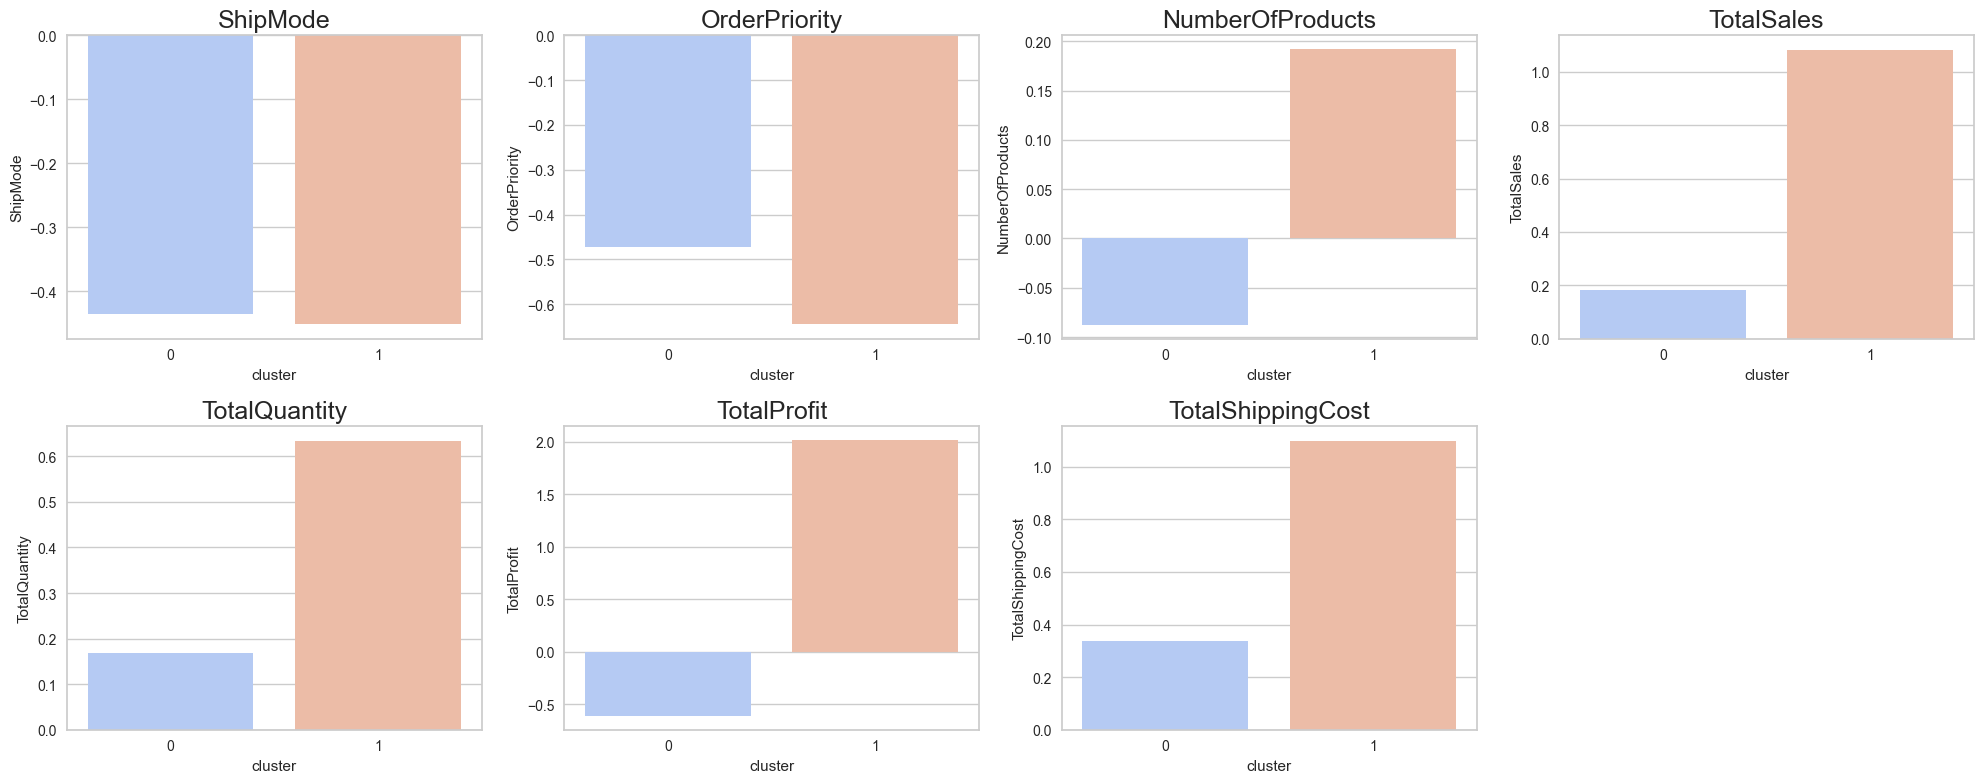

In [27]:
plot_clusters(df_agg)

#### Radar plot

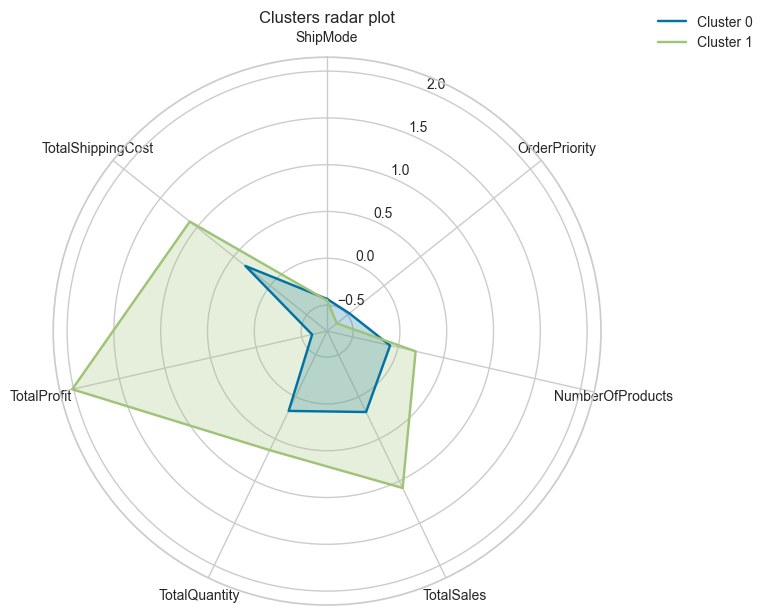

In [28]:
# Select variables to display in radar plot
variables = ['ShipMode', 'OrderPriority', 'NumberOfProducts', 'TotalSales',
       'TotalQuantity', 'TotalProfit', 'TotalShippingCost']

plot_radar(df_agg, variables)

#### Histograms

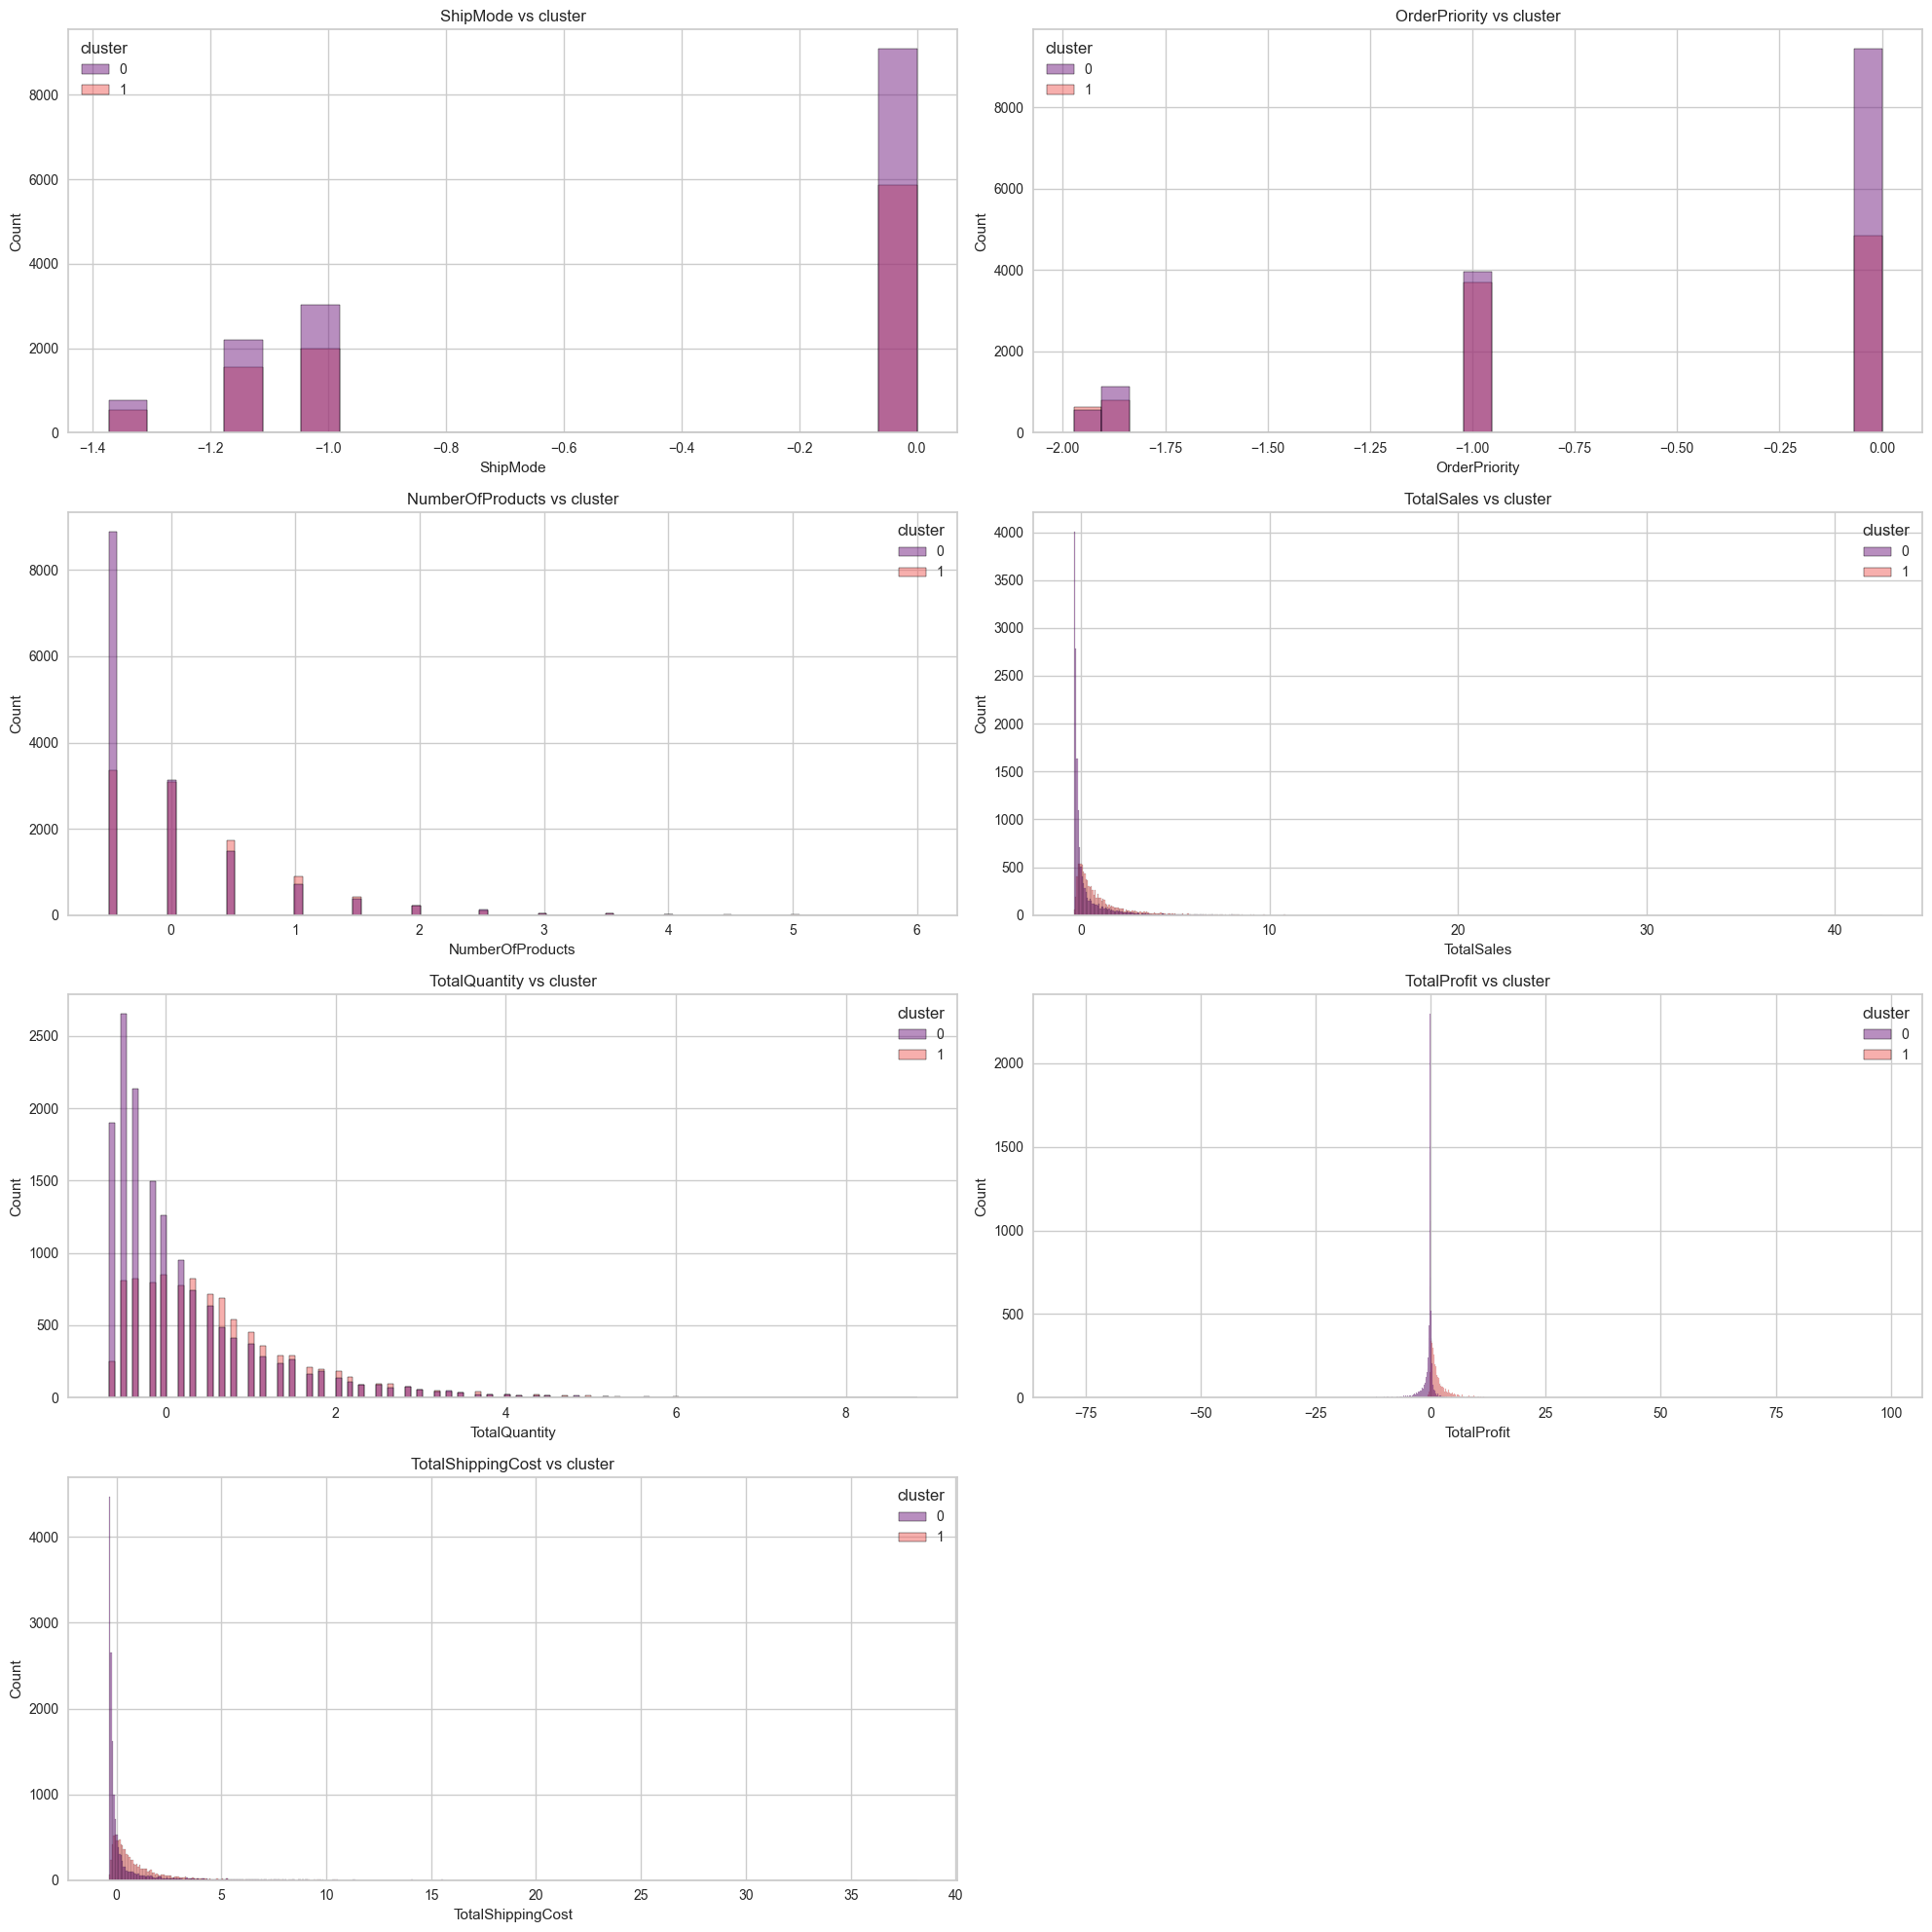

In [29]:
plot_relation_tv(df_agg, 'cluster', size=(20,20), n_cols = 2)

In this case, the clusters are more difficult to interpret. We will not use this algorithm.

## 4.3 Spectral clustering

This method takes a long time to run on this dataset, so we will discard it for now.

## 4.4 DBSCAN Clustering

Next, let’s try the DBSCAN method with different values of epsilon and min_samples.

In [32]:
dbscan_methods(df_scaled, eps_values=[1, 5, 10], min_samples_values=[10, 15, 20, 25])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
8,10,10,0.930933,1.896701,"{-1: 13, 0: 25022}"
9,10,15,0.926983,2.733012,"{-1: 16, 0: 25019}"
10,10,20,0.926983,2.733012,"{-1: 16, 0: 25019}"
11,10,25,0.926983,2.733012,"{-1: 16, 0: 25019}"
4,5,10,0.891609,2.200079,"{-1: 48, 0: 24987}"
5,5,15,0.885100,1.903719,"{-1: 63, 0: 24972}"
6,5,20,0.878772,1.614662,"{-1: 77, 0: 24958}"
7,5,25,0.876310,1.589692,"{-1: 81, 0: 24954}"
2,1,20,0.060295,2.141329,"{-1: 3639, 0: 13139, 1: 5072, 2: 3185}"
3,1,25,0.059996,2.095033,"{-1: 3899, 0: 13021, 1: 4966, 2: 3149}"


In this case, different combinations of `epsilon` and `min_samples` they provide models with acceptable metrics but with unhelpful cardinality, as one cluster is very large while the other contains very few entries.  

This suggests that it is likely not the appropriate method for clustering and that the entries in the smaller cluster are more likely outliers.

For now, we will discard the DBSCAN method for clustering.

# 5. Conclusions

Only the clustering using the K-Means method is useful to us, as it provides two well-differentiated clusters: orders that generate profits and orders that do not.

# 6 Data saving

In [39]:
df.head()

,ShipMode,OrderPriority,NumberOfProducts,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
OrderID,,,,,,,
AE-2011-9160,Standard Class,Medium,2,161.082,8,-246.078,9.56
AE-2013-1130,Same Day,High,2,228.996,7,-236.964,60.18
AE-2013-1530,Second Class,High,2,23.634,3,-38.076,3.16
AE-2014-2840,First Class,Critical,1,42.480,1,-75.060,8.04
AE-2014-3830,Standard Class,Medium,6,281.502,16,-429.108,19.38


In [40]:
df_kmeans.head()

,ShipMode,OrderPriority,NumberOfProducts,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost,cluster
OrderID,,,,,,,,
AE-2011-9160,0.000000,0.000000,0.0,-0.082849,0.500000,-2.984602,-0.183791,0
AE-2013-1130,-1.371906,-1.000000,0.0,0.040169,0.333333,-2.882397,0.755007,0
AE-2013-1530,-1.000000,-1.000000,0.0,-0.331819,-0.333333,-0.652053,-0.302485,0
AE-2014-2840,-1.127490,-1.857594,-0.5,-0.297682,-0.666667,-1.066794,-0.211981,0
AE-2014-3830,0.000000,0.000000,2.0,0.135277,1.833333,-5.037113,-0.001669,1


In [36]:
df_clusters = pd.concat([df, df_kmeans['cluster']], axis=1)

In [38]:
df_clusters.to_csv('../data/processed/orders_clusters.csv')